# Temporal Similarity Search on KDB+ HDB for Pattern Matching and Outlier Search

>*Note: This example requires an instance of KDB.AI Server to be installed locally to where you run this notebook - see section 2 for details.*

This notebook demonstrates how to perform Temporal Similarity Search (TSS) for advanced pattern matching and outlier search on stock price data stored in a [kdb+ Historical Database (HDB)](https://code.kx.com/kdbai/latest/integrations/kdb.html). With this approach, you can search for recurring temporal patterns, detect anomalies, and perform outlier searches—all without the need to move data or create embeddings.

The key advantage of this workflow is the seamless integration with your existing kdb+ environment. By keeping the data in kdb+, we leverage the system's high-performance time-series capabilities for efficient TSS, allowing you to run searches and analyses directly on your historical stock data.

Agenda:
1. Dependencies, Imports & Setup
1. Start KDB.AI Session 
1. Perform temporal similarity searches to identify patterns in stock price movements
1. Execute outlier detection to flag unusual patterns or price movements

Let's get started with leveraging kdb+ and KDB.AI to optimize temporal pattern recognition and stock price analysis.



### 1. Dependencies, Imports & Setup

In order to successfully run this sample, note the following steps depending on where you are running this notebook:

-***Run Locally / Private Environment:*** The [Setup](https://github.com/KxSystems/kdbai-samples/blob/main/README.md#setup) steps in the repository's `README.md` will guide you on prerequisites and how to run this with Jupyter.

-***Colab / Hosted Environment:*** Open this notebook in Colab and run through the cells.


In [ ]:
!pip install kdbai_client

In [1]:
import kdbai_client as kdbai
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time
import zipfile
import os

#### Dataset Overview
A kdb+ HDB dataset of 10 million data points across 10 different stocks (symbols) using a random walk  has been created for you. It contains the following data:

- timestamp: The timestamp for the data
- sym: The ticket symbol of the stock being traded
- price: The price of the stock being traded at a certain timestamp
- volume: The traded volume of the stock being traded.

Let's unzip this dataset (demo_hdb) so its ready to use in the next step.

In [ ]:
# Specify the path to your ZIP file
zip_file_path = 'demo_hdb.zip'  

# Get the current working directory
current_directory = os.getcwd()

# Open the ZIP file and extract its contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(current_directory)

print(f"Extracted all files to: {current_directory}")

If you're interested in how this synthetic dataset was created you can see the code in createHDB.q. Also if you'd prefer to run this sample using qAPI instead of Python API the q version of the notebook linked [here](https://code.kx.com/kdbai/latest/integrations/kdb.html#drop-table).

## 2. Start KDB.AI Server and Define KDB.AI Session

>*Note: The kdb+ integration demonstrated in this notebook is only available with KDB.AI Server and not KDB.AI Cloud.*

To use KDB.AI Server, you will need download and run your own container. To do this, you will first need to sign up for free [here](https://code.kx.com/kdbai/gettingStarted/kdb-ai-server-setup.html).

You will receive an email with the required license file and bearer token needed to download your instance. Follow instructions in the signup email to get your session up and running.

To start a KDB.AI session using on disk kdb+ data you should start your local KDB.AI Server with a volume mount to the location of your data (demo_hdb). 

```
docker run -it \
  -e KDB_LICENSE_B64="$KDB_LICENSE_B64" \  # Set the KDB license environment variable
  -v <PATH_TO_HDB>/demo_hdb:/db \  # Bind mount demo HDB directory, replace PATH_TO_HDB
  -p 8082:8082 \  # Map port 8082 for web access
  portal.dl.kx.com/kdbai-db:1.4.0  # Specify the Docker image to run

```

Then connect using `kdbai.Session()` and mount the trade table in our demo_hdb database.

In [ ]:
s = kdbai.Session()
db = s.database("default")

# First ensure the table does not already exist
try:
    db.table("trade").drop()
    time.sleep(5)
except kdbai.KDBAIException:
    pass

table = db.create_table(table="trade",external_data_references=[{"path":b'/db', "provider" :"kx"}],partition_column="date")

In [3]:
table.query()

,date,sym,time,price,size
0,2024-08-19,AAPL,2024-08-19 09:30:00.001,218.00,46
1,2024-08-19,AAPL,2024-08-19 09:30:01.029,217.95,93
2,2024-08-19,AAPL,2024-08-19 09:30:01.061,217.90,80
3,2024-08-19,AAPL,2024-08-19 09:30:01.154,217.92,86
4,2024-08-19,AAPL,2024-08-19 09:30:01.265,217.83,67
...,...,...,...,...,...
9999995,2024-08-30,TSLA,2024-08-30 15:59:59.093,233.51,38
9999996,2024-08-30,TSLA,2024-08-30 15:59:59.249,233.56,24
9999997,2024-08-30,TSLA,2024-08-30 15:59:59.770,233.43,68
9999998,2024-08-30,TSLA,2024-08-30 15:59:59.824,233.47,50


## 3. Pattern Matching

In this section, we will perform pattern matching using predefined stock price patterns.

1. **Define Patterns**: Start by defining each pattern in Q.

2. **Similarity Search**: Conduct a similarity search for each pattern of varying lengths against the synthetic market time series data stored in the HDB. This process involves querying the database to find the sequence most similar to our predefined patterns.

3. **Visualisation**: For each pattern, visualise both the normalised synthetic pattern and the most similar pattern found in the synthetic data. This visual representation aids in evaluating the performance of the similarity search.

4. **Result Analysis**: The results of the similarity search are printed, showing the most similar timestamp and pattern from the synthetic data. We then attempt to map these findings back to the original synthetic data to verify and assess the similarity.

This approach can be used to leverage synthetic price movements in identifying significant price trends within real data.


### Define Patterns

In this section, we define a set of patterns. The primary goal of these functions, `patternA`, `patternB`, `patternC`, and `patternD`.

The goal is to use these for similarity searches, allowing us to compare different patterns and identify relationships between them.

In [4]:
patternA = np.array([0, 2, 4, 6, 8, 7, 6, 5, 4, 6, 8, 10, 12, 10, 8, 6, 4, 5, 6, 7, 8, 6, 4, 2, 0])
patternB = np.array([0, 2, 4, 6, 8, 10, 12, 14, 16, 15, 14, 13, 12, 13, 14, 15, 16, 14, 12, 10, 8, 6, 4, 2, 0])
patternC = np.array([0, 2, 4, 6, 8, 6.5, 5.0, 3.5, 2.0, 3.5, 5.0, 6.5, 8.0, 6.5, 5.0, 3.5, 2.0, 3.5, 5.0, 6.5, 8.0, 6, 4, 2, 0])
patternD = np.array([0, 1, 2, 3, 4, 3.5, 3.0, 2.5, 2.0, 4.0, 6.0, 8.0, 10.0, 8.0, 6.0, 4.0, 2.0, 2.5, 3.0, 3.5, 4.0, 3, 2, 1, 0])

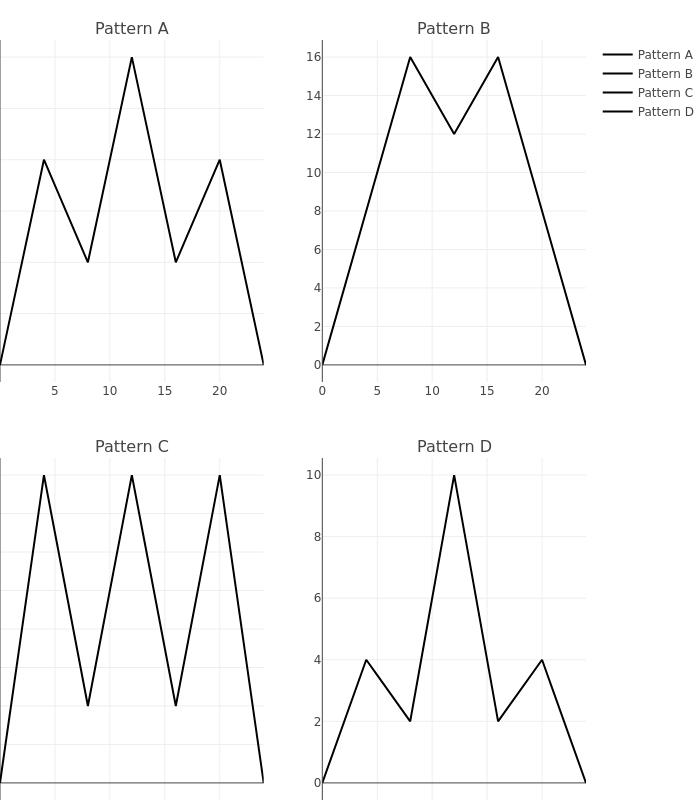

In [6]:
fig = make_subplots(
    rows=2, cols=2, 
    subplot_titles=("Pattern A", "Pattern B", "Pattern C", "Pattern D"), 
    vertical_spacing=0.1
)

fig.add_trace(go.Scatter(mode='lines', y=patternA, name='Pattern A'), row=1, col=1)
fig.add_trace(go.Scatter(mode='lines', y=patternB, name='Pattern B'), row=1, col=2)
fig.add_trace(go.Scatter(mode='lines', y=patternC, name='Pattern C'), row=2, col=1)
fig.add_trace(go.Scatter(mode='lines', y=patternD, name='Pattern D'), row=2, col=2)

fig.update_layout(
    height=800, 
    margin=dict(l=0, t=40, r=0, b=0)
)

fig.show("png")

### Temporal Similarity Search 

In this section, we conduct a similarity search for each of the four patterns on a single symbol (AAPL) over a specified date range, returning the five closest matches for each pattern.

Searching just for patternA:

In [7]:
res=table.search(
    {"price": patternA.reshape(1, -1)},
    type="tss",
    n=5,
    filter=[("=", "sym", "AAPL")],
    options=dict(force=True, returnMatches=True))
res

[        date   sym                    time   price  size  nnIdx    nnDist  \
 0 2024-08-23  AAPL 2024-08-23 14:38:41.571  238.66    82  79172  1.785228   
 1 2024-08-27  AAPL 2024-08-27 13:55:08.851  273.48    25  68064  2.179401   
 2 2024-08-28  AAPL 2024-08-28 13:32:39.735  265.46    20  62436  2.191350   
 3 2024-08-22  AAPL 2024-08-22 15:59:12.574  246.93    43  99800  2.238873   
 4 2024-08-29  AAPL 2024-08-29 14:11:50.317  291.01    82  72220  2.298780   
 
                                              nnMatch  
 0  [238.66, 238.62, 238.75, 238.89000000000001, 2...  
 1  [273.48, 273.58, 273.63, 273.75, 273.82, 273.7...  
 2  [265.46, 265.45, 265.59000000000003, 265.62, 2...  
 3  [246.93, 247.05, 247.07, 247.23000000000002, 2...  
 4  [291.01, 291.11, 291.22, 291.31, 291.31, 291.2...  ]

Searching for all 4 patterns:

In [8]:
# Reshape patterns to ensure they are 2D
patternA = patternA.reshape(1, -1) 
patternB = patternB.reshape(1, -1) 
patternC = patternB.reshape(1, -1) 
patternD = patternB.reshape(1, -1) 

# Create a combined input with both patterns
combined_patterns = np.vstack((patternA, patternB,patternC,patternD))  # Stack vertically

res=table.search(
    {"price": combined_patterns.tolist()},
    type="tss",
    n=5,
    filter=[("=", "sym", "AAPL")],
    options=dict(force=True, returnMatches=True))

Define the python functions to plot dataframes and graphs.

In [9]:
def process_pattern(pattern_res, pattern_p):
    pattern_df = res[pattern_res]

    # Combine 'sym' and 'time' into one column
    sym_time = pattern_df['sym'] + ' ' + pattern_df['time'].astype(str)

    # Convert 'nnMatch' to DataFrame and adjust columns
    nnMatch_df = pd.DataFrame(np.stack(pattern_df['nnMatch'].values).T)
    nnMatch_df.columns = sym_time

    # Normalise the pattern
    q = combined_patterns[pattern_p]
    q = (q - q.mean()) / q.std()

    # Normalize the nnMatch_df
    for c in nnMatch_df.columns:
        nnMatch_df[c] = (nnMatch_df[c] - nnMatch_df[c].mean()) / nnMatch_df[c].std()

    # Return both the original and nnMatch_df
    return pattern_df, nnMatch_df, q


# Function to plot the pattern and its corresponding nearest neighbour matches
def plot_pattern(nnMatch_df, q, pattern_name):
    fig = px.line(nnMatch_df, height=600, render_mode='webgl')
    
    # Define a colour sequence for the traces
    color_sequence = ['red', 'green', 'blue', 'purple', 'cyan', 'magenta', 'yellow', 'black', 'gray', 'brown']
    
    # Update the traces' line colours and opacity
    for i, trace in enumerate(fig.data):
        trace.update(line=dict(color=color_sequence[i % len(color_sequence)]), opacity=0.3)
    
    # Add the pattern 'q' as an additional trace
    fig.add_trace(go.Scattergl(
        mode='lines',
        y=q,
        line=dict(width=3, color='orange'),
        name=pattern_name
    ))
    
    # Update layout for better visualization
    fig.update_layout(
        hovermode='closest',
        title=f'{pattern_name} Plot',
        xaxis_title='Index',
        yaxis_title='Value'
    )
    
    return fig


        date   sym                    time   price  size  nnIdx    nnDist  \
0 2024-08-23  AAPL 2024-08-23 14:38:41.571  238.66    82  79172  1.785228   
1 2024-08-27  AAPL 2024-08-27 13:55:08.851  273.48    25  68064  2.179401   
2 2024-08-28  AAPL 2024-08-28 13:32:39.735  265.46    20  62436  2.191350   
3 2024-08-22  AAPL 2024-08-22 15:59:12.574  246.93    43  99800  2.238873   
4 2024-08-29  AAPL 2024-08-29 14:11:50.317  291.01    82  72220  2.298780   

                                             nnMatch  
0  [238.66, 238.62, 238.75, 238.89000000000001, 2...  
1  [273.48, 273.58, 273.63, 273.75, 273.82, 273.7...  
2  [265.46, 265.45, 265.59000000000003, 265.62, 2...  
3  [246.93, 247.05, 247.07, 247.23000000000002, 2...  
4  [291.01, 291.11, 291.22, 291.31, 291.31, 291.2...  


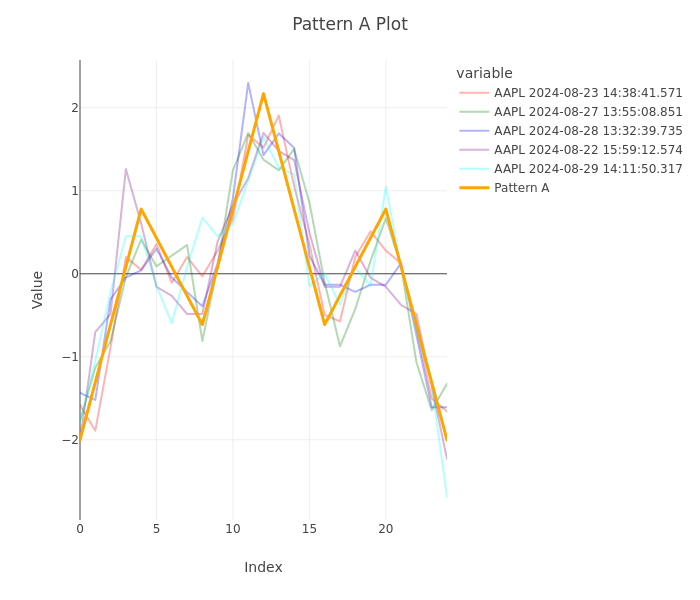

        date   sym                    time   price  size  nnIdx    nnDist  \
0 2024-08-21  AAPL 2024-08-21 11:50:07.309  218.24    46  35815  1.052655   
1 2024-08-22  AAPL 2024-08-22 11:59:24.140  268.93    40  38175  1.316181   
2 2024-08-21  AAPL 2024-08-21 10:04:34.018  230.41    28   9064  1.326923   
3 2024-08-19  AAPL 2024-08-19 15:10:19.251  230.77    76  87237  1.333702   
4 2024-08-27  AAPL 2024-08-27 14:24:44.317  270.15    60  75693  1.347826   

                                             nnMatch  
0  [218.24, 218.24, 218.35, 218.46, 218.43, 218.5...  
1  [268.93, 268.95, 269.03000000000003, 269.16, 2...  
2  [230.41, 230.48000000000002, 230.5, 230.47, 23...  
3  [230.77, 230.86, 230.89000000000001, 230.94, 2...  
4  [270.15, 270.23, 270.3, 270.28000000000003, 27...  


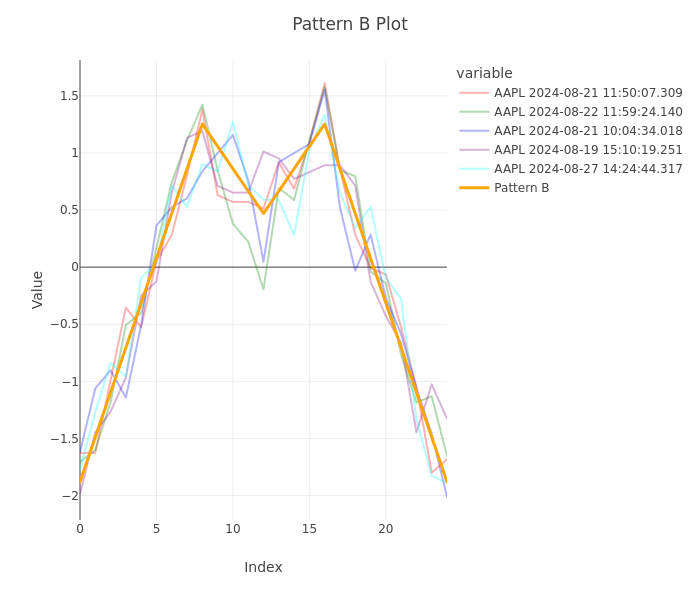

        date   sym                    time   price  size  nnIdx    nnDist  \
0 2024-08-21  AAPL 2024-08-21 11:50:07.309  218.24    46  35815  1.052655   
1 2024-08-22  AAPL 2024-08-22 11:59:24.140  268.93    40  38175  1.316181   
2 2024-08-21  AAPL 2024-08-21 10:04:34.018  230.41    28   9064  1.326923   
3 2024-08-19  AAPL 2024-08-19 15:10:19.251  230.77    76  87237  1.333702   
4 2024-08-27  AAPL 2024-08-27 14:24:44.317  270.15    60  75693  1.347826   

                                             nnMatch  
0  [218.24, 218.24, 218.35, 218.46, 218.43, 218.5...  
1  [268.93, 268.95, 269.03000000000003, 269.16, 2...  
2  [230.41, 230.48000000000002, 230.5, 230.47, 23...  
3  [230.77, 230.86, 230.89000000000001, 230.94, 2...  
4  [270.15, 270.23, 270.3, 270.28000000000003, 27...  


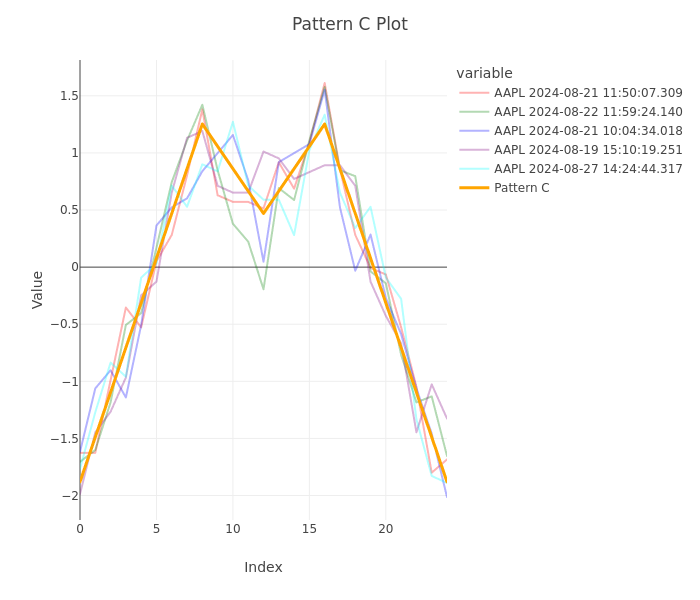

        date   sym                    time   price  size  nnIdx    nnDist  \
0 2024-08-21  AAPL 2024-08-21 11:50:07.309  218.24    46  35815  1.052655   
1 2024-08-22  AAPL 2024-08-22 11:59:24.140  268.93    40  38175  1.316181   
2 2024-08-21  AAPL 2024-08-21 10:04:34.018  230.41    28   9064  1.326923   
3 2024-08-19  AAPL 2024-08-19 15:10:19.251  230.77    76  87237  1.333702   
4 2024-08-27  AAPL 2024-08-27 14:24:44.317  270.15    60  75693  1.347826   

                                             nnMatch  
0  [218.24, 218.24, 218.35, 218.46, 218.43, 218.5...  
1  [268.93, 268.95, 269.03000000000003, 269.16, 2...  
2  [230.41, 230.48000000000002, 230.5, 230.47, 23...  
3  [230.77, 230.86, 230.89000000000001, 230.94, 2...  
4  [270.15, 270.23, 270.3, 270.28000000000003, 27...  


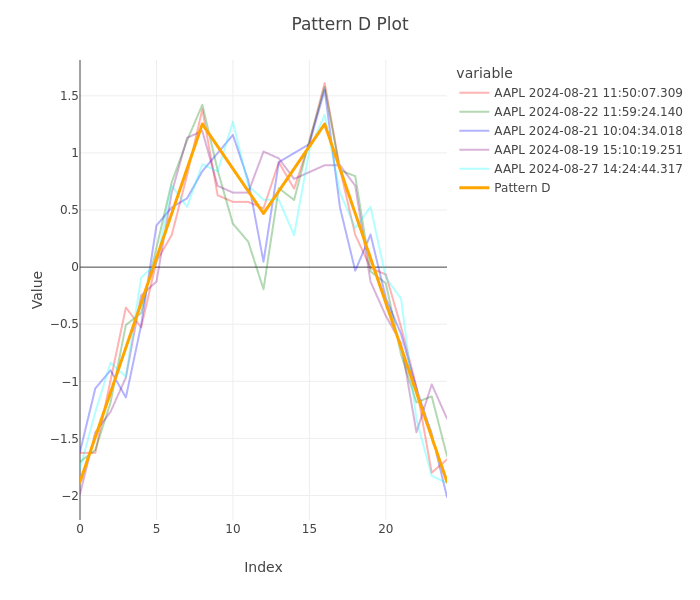

In [10]:
# List of pattern result names and pattern names
pattern_results = [0,1,2,3]
pattern_names = ['Pattern A', 'Pattern B', 'Pattern C', 'Pattern D']
pattern_p = [0,1,2,3]

# Process and plot each pattern in a loop
for i in range(4):
    pattern_df, nnMatch_df, q = process_pattern(pattern_results[i], pattern_p[i])
    
    # Plot using the normalized nnMatch_df
    print(pattern_df.head())
    fig = plot_pattern(nnMatch_df, q, pattern_names[i])
    fig.show("png")

The visualizations demonstrate how the predefined patterns, align with the synthetic stock data over time. This analysis reveals several key insights:

- Pattern Recognition: The matching scores indicate periods where the synthetic stock prices exhibit behaviors similar to the identified patterns. High matching scores suggest that specific market conditions or trends are being accurately captured, which can be crucial for understanding price movements.

- Market Dynamics: Observing the temporal alignment allows us to identify how certain patterns correlate with market events or price fluctuations. Recognizing these correlations can help traders anticipate potential market movements based on historical trends.
- Risk Management: By leveraging pattern matching, traders can develop more robust risk management strategies. For instance, if a specific pattern frequently precedes a downturn, this information can inform decisions about when to exit positions or adjust portfolios.

- Algorithmic Trading: The insights gained from these visualizations can be integrated into algorithmic trading systems. By programming algorithms to recognize and respond to these patterns in real-time, traders can automate buy and sell decisions, potentially capitalizing on market opportunities more effectively.

- Strategy Development: This analysis serves as a foundation for developing trading strategies. By understanding which patterns yield successful outcomes, traders can refine their strategies to enhance performance and profitability.

## 4. Search for Outliers

3. **Outlier Search**: Perform an outlier search for each normalised pattern against the synthetic market time series data in the HDB. This step queries the database for the sequence that is least similar to the patterns.


Another key feature of Non-Transformed Temporal Similarity Search is outlier detection, which identifies the most dissimilar vectors.

To perform this search, set 𝑛 to the negative value of the number of dissimilar results you want to retrieve (e.g. 𝑛 = −5). Additionally, modifying the pattern length will adjust the sliding window range used during the search.

In [11]:
res = table.search(
    {"price": combined_patterns.tolist()},
    type="tss",
    n=-5,
    filter=[("=", "sym", "NVDA")],
    options=dict(force=True, returnMatches=True)
)

        date   sym                    time   price  size   nnIdx    nnDist  \
0 2024-08-29  NVDA 2024-08-29 10:49:45.487  393.77    65  720346  9.799948   
1 2024-08-27  NVDA 2024-08-27 15:20:36.757  418.57    72  789862  9.765645   
2 2024-08-28  NVDA 2024-08-28 15:55:28.179  428.42    46  798789  9.745112   
3 2024-08-21  NVDA 2024-08-21 14:33:53.295  409.10    63  777845  9.740116   
4 2024-08-22  NVDA 2024-08-22 10:52:49.310  417.84    96  721097  9.735033   

                                             nnMatch  
0  [393.77, 393.7, 393.46000000000004, 393.340000...  
1  [418.57, 418.34000000000003, 418.24, 418.35, 4...  
2  [428.42, 428.33, 428.17, 428.09000000000003, 4...  
3  [409.1, 408.94, 408.79, 408.74, 408.6500000000...  
4  [417.84000000000003, 417.59000000000003, 417.5...  


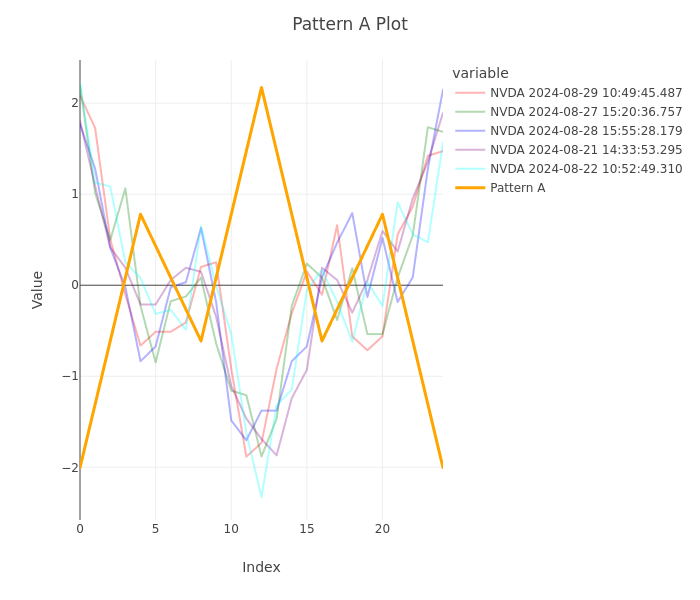

        date   sym                    time   price  size   nnIdx    nnDist  \
0 2024-08-29  NVDA 2024-08-29 11:01:31.230  384.39    11  723398  9.920381   
1 2024-08-22  NVDA 2024-08-22 15:35:46.897  397.67    67  793651  9.919833   
2 2024-08-29  NVDA 2024-08-29 13:27:00.608  396.07    16  760825  9.917246   
3 2024-08-20  NVDA 2024-08-20 15:29:26.416  452.49    73  792179  9.916484   
4 2024-08-28  NVDA 2024-08-28 13:06:39.815  416.63    44  755384  9.910316   

                                             nnMatch  
0  [384.39, 384.29, 384.18, 384.06, 384.07, 383.9...  
1  [397.67, 397.53000000000003, 397.63, 397.49, 3...  
2  [396.07, 395.92, 395.74, 395.73, 395.62, 395.4...  
3  [452.49, 452.2, 452.24, 452.21000000000004, 45...  
4  [416.63, 416.64, 416.56, 416.41, 416.340000000...  


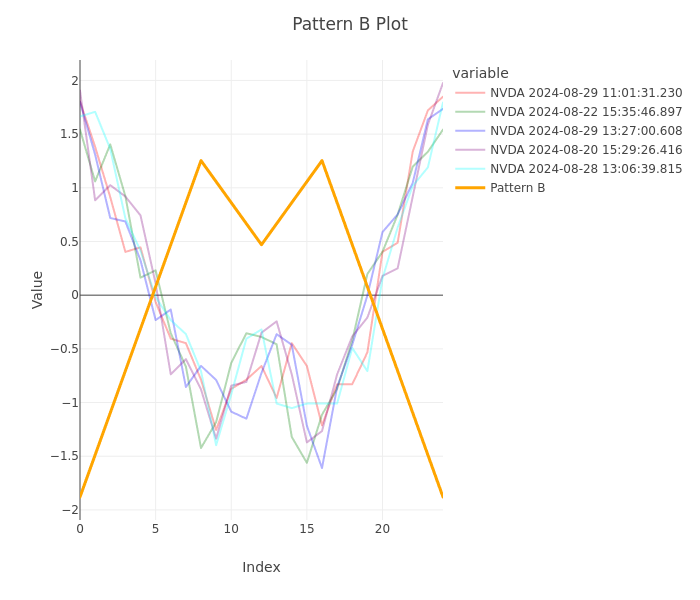

        date   sym                    time   price  size   nnIdx    nnDist  \
0 2024-08-29  NVDA 2024-08-29 11:01:31.230  384.39    11  723398  9.920381   
1 2024-08-22  NVDA 2024-08-22 15:35:46.897  397.67    67  793651  9.919833   
2 2024-08-29  NVDA 2024-08-29 13:27:00.608  396.07    16  760825  9.917246   
3 2024-08-20  NVDA 2024-08-20 15:29:26.416  452.49    73  792179  9.916484   
4 2024-08-28  NVDA 2024-08-28 13:06:39.815  416.63    44  755384  9.910316   

                                             nnMatch  
0  [384.39, 384.29, 384.18, 384.06, 384.07, 383.9...  
1  [397.67, 397.53000000000003, 397.63, 397.49, 3...  
2  [396.07, 395.92, 395.74, 395.73, 395.62, 395.4...  
3  [452.49, 452.2, 452.24, 452.21000000000004, 45...  
4  [416.63, 416.64, 416.56, 416.41, 416.340000000...  


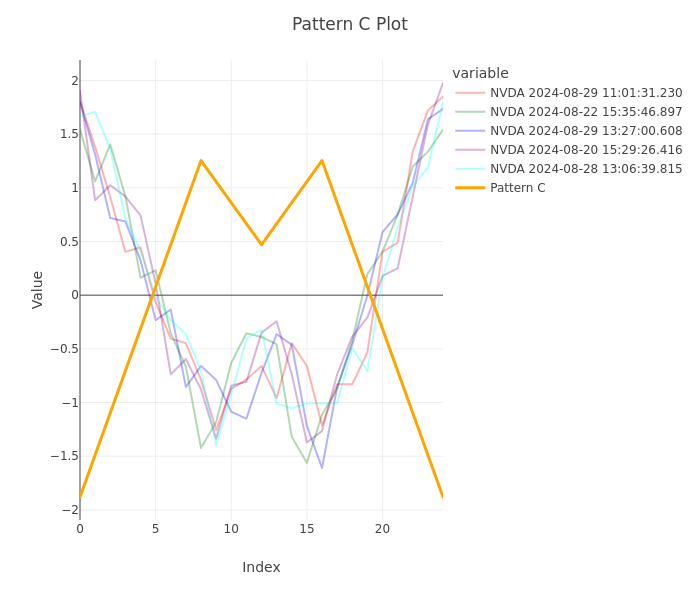

        date   sym                    time   price  size   nnIdx    nnDist  \
0 2024-08-29  NVDA 2024-08-29 11:01:31.230  384.39    11  723398  9.920381   
1 2024-08-22  NVDA 2024-08-22 15:35:46.897  397.67    67  793651  9.919833   
2 2024-08-29  NVDA 2024-08-29 13:27:00.608  396.07    16  760825  9.917246   
3 2024-08-20  NVDA 2024-08-20 15:29:26.416  452.49    73  792179  9.916484   
4 2024-08-28  NVDA 2024-08-28 13:06:39.815  416.63    44  755384  9.910316   

                                             nnMatch  
0  [384.39, 384.29, 384.18, 384.06, 384.07, 383.9...  
1  [397.67, 397.53000000000003, 397.63, 397.49, 3...  
2  [396.07, 395.92, 395.74, 395.73, 395.62, 395.4...  
3  [452.49, 452.2, 452.24, 452.21000000000004, 45...  
4  [416.63, 416.64, 416.56, 416.41, 416.340000000...  


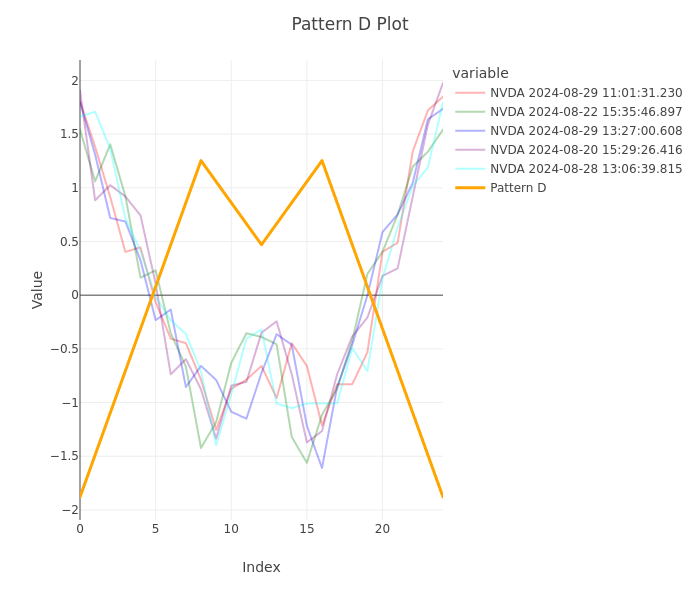

In [13]:
# List of pattern result names and pattern names
pattern_results = [0,1,2,3]
pattern_names = ['Pattern A', 'Pattern B', 'Pattern C', 'Pattern D']
pattern_p = [0,1,2,3]

# Process and plot each pattern in a loop
for i in range(4):
    pattern_df, nnMatch_df, q = process_pattern(pattern_results[i], pattern_p[i])
    
    # Plot using the normalized nnMatch_df
    print(pattern_df.head())
    fig = plot_pattern(nnMatch_df, q, pattern_names[i])
    fig.show("png")


The results from the outlier search to identify the least similar patterns within the synthetic stock data could be crucial for uncovering unexpected behaviors that deviate from established trends in real life. Here are the key findings from the outlier search:

- Identification of Anomalies: The outlier search revealed patterns that exhibit significant deviations from the expected behavior represented by patternA and patternB. Identifying these anomalies is essential for understanding underlying market dynamics that may not conform to typical trends.

- Market Volatility: The patterns classified as outliers often coincide with periods of increased volatility or unusual market events. Recognizing these outliers can provide insights into potential market disruptions, helping traders stay informed about risks that may not be apparent through standard analyses.

- Refining Trading Strategies: By examining the characteristics of these outlier patterns, traders can gain a deeper understanding of market anomalies. This knowledge can be instrumental in refining trading strategies, allowing for more adaptive responses to unexpected market conditions.

- Enhanced Decision-Making: Outlier detection adds a layer of depth to market analysis. Understanding what constitutes a significant deviation helps traders differentiate between normal fluctuations and potential signals for action, such as reassessing positions or employing protective strategies.

- Future Research: The findings from the outlier search can inform future research endeavors. Analyzing the causes and implications of these outlier patterns may lead to the development of new models or strategies that account for market anomalies more effectively.

In summary, the outlier search complements our temporal pattern matching analysis by highlighting significant deviations in market behavior. By integrating these insights, traders and analysts can enhance their understanding of market dynamics and improve their decision-making processes in real-world trading scenarios.

## 5. Drop the Table
Once finished with the table, it is best practice to drop it.

In [ ]:
db.table("trade").drop()